In [1]:
import tone
import utils
from utils import *

tone.utils.ipython.autoreload(utils)
tone.utils.learning.ignore_warning()
device = tone.utils.learning.try_use_device()
device

device(type='cuda')

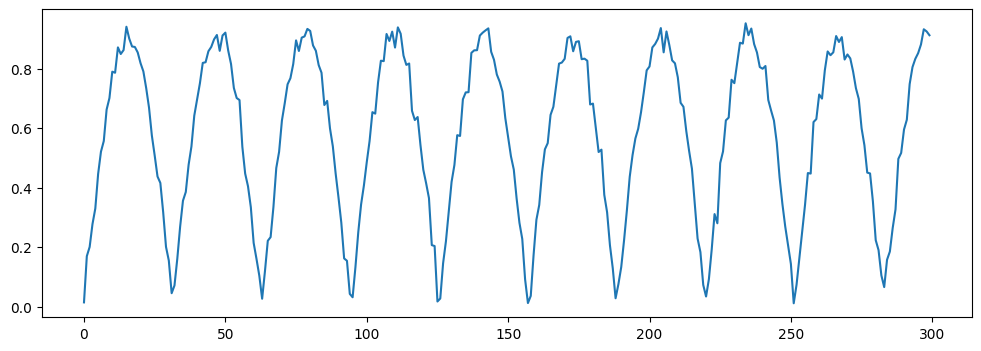

In [2]:
data = utils.SineDataset(lags=12).data.detach().cpu().numpy()
fig = plt.figure(figsize=(12, 4))
ax = fig.subplots()
ax.plot(data[:300])
plt.show()

In [3]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

def forecast(history):

    model = ExponentialSmoothing(
        history,
        trend='add',
        damped_trend=True,
        use_boxcox=True,
    ).fit(optimized=True)

    pred = model.predict(len(history), len(history))
    return pred[0]

In [4]:
models = utils.load_models()

stats = tone.utils.attrdict.defaultattrdict()
stats.ets.forward = forecast

100%|██████████| 487/487 [00:06<00:00, 72.97it/s]


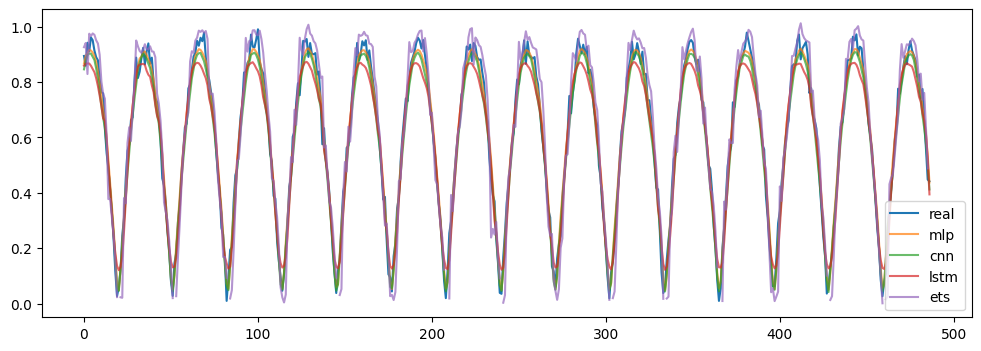

In [5]:
lags = 12

dataloader = torch.utils.data.DataLoader(
    dataset=utils.SineDataset(lags, train=False, len=500),
    batch_size=1,
    drop_last=True,
    shuffle=False,
    generator=torch.Generator(device=device),
)


real = []
for model in models.values():
    model.pred = []

for model in stats.values():
    model.pred = []

for x, t in tqdm(dataloader):
    real.append(t)
    for model in models.values():
        y = model.forward(x)
        model.pred.append(y)
    for model in stats.values():
        y = model.forward(x.reshape(-1).cpu().numpy())
        model.pred.append(y)

real = torch.cat(real).detach().cpu()
for model in models.values():
    model.pred = torch.cat(model.pred).detach().cpu()

fig = plt.figure(figsize=(12, 4))
ax = fig.subplots()
ax.plot(real, label='real')
for name, model in models.items():
    ax.plot(model.pred, alpha=0.7, label=name)

for name, model in stats.items():
    ax.plot(model.pred, alpha=0.7, label=name)

plt.legend()
plt.show()
plt.close()


In [6]:
results = {}

for model in list(models.values()) + list(stats.values()):
    err = tone.utils.attrdict.attrdict()
    pred = np.array(model.pred)
    pred[np.isnan(pred)] = 0.0

    err.mape = metrics.mean_absolute_percentage_error(real, pred)
    err.mse = metrics.mean_squared_error(real, pred)
    err.rmse = np.sqrt(err.mse)
    err.mae = metrics.mean_absolute_error(real, pred)
    err.vs = metrics.explained_variance_score(real, pred)
    err.r2 = metrics.r2_score(real, pred)
    model.err = err

df = pd.DataFrame()
df['metric'] = err.keys()

for name, model in models.items():
    df[name] = model.err.values()

for name, model in stats.items():
    df[name] = model.err.values()

df

,metric,mlp,cnn,lstm,ets
0,mape,0.114806,0.105966,0.240003,0.208964
1,mse,0.001124,0.001724,0.003134,0.006262
2,rmse,0.033530,0.041522,0.055978,0.079133
3,mae,0.027429,0.033750,0.046066,0.061343
4,vs,0.986353,0.986519,0.967807,0.924504
5,r2,0.986265,0.978938,0.961719,0.923499
